# Model Training

This notebook contains steps to create a classification model (kmeans=5, sim_label=20, target encoded sequences, one hot encoded similarity label)

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from interpolation import CensusData, sequences, BlockInterpolator, CentroidInterpolator, archive, interpolation
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

from kmodes.kmodes import KModes
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


## read in data

In [2]:
#Change these values to rerun the notebook
filled_1850 = pd.read_csv("../../data/dwelling_filled_sum_1850_mn_v01.csv")
cd_1850 = pd.read_csv("../../data/cd_1850_XYupdate.csv") #For calculating centroids
filled_1850.rename(columns = {"CENSUS_WARD_NUM":"Ward_Num", "CENSUS_SERIALP":"CENSUS_SERIALB", "BLOCK_NUM":"block_num", "CENSUS_REEL_HOUSEHOLD":"CENSUS_REEL", "CENSUS_SEX":"CENSUS_SEXB", "CENSUS_PAGENO_HOUSEHOLD":"CENSUS_PAGENUM", "CENSUS_RACE":"CENSUS_RACEB", "CD_X":"cd_X", "CD_Y":"cd_Y"}, inplace = True)
ward_col = "Ward_Num"
dwelling_col = "dwelling_id"
dwelling_col_num = "CENSUS_DWELLING_NUM"
block_col = "block_num"
x_col = "cd_X"
y_col = "cd_Y"
pagenum = "CENSUS_PAGENNO"

In [3]:
print(filled_1850.shape)
print(filled_1850.loc[~filled_1850['block_num'].isnull()].shape)
print(filled_1850.loc[filled_1850['block_num'].isnull()].shape)

(515630, 32)
(166500, 32)
(349130, 32)


In [4]:
#set clustering algo -- this is to make sure that the same clustering algorithm is used
#for each model, to ensure that testing is accurate
#note fitting before hand won't work for all types of clustering, for example, with agglomerative
#clustering this isn't going to work because the algorithm doesn't have a predict method
block_centroids = {ward:{block:interpolation.make_centroid(df_block[x_col], df_block[y_col]) for block, df_block in df.groupby(block_col)} for ward,df in cd_1850.groupby(ward_col)}

In [5]:
enumerators = pd.read_csv("../../data/census_1850_enumerationDetail_mn_ward10.csv")

In [6]:
ward10 = filled_1850[filled_1850[ward_col] == 10]
ward10_enumerators = ward10.merge(enumerators,  how = "left", left_on= "CENSUS_PAGENUM", right_on = "CENSUS_PAGENO_HOUSEHOLD")

## create sequences

In [7]:
census_enum_seq = CensusData(ward10_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, 
                             block_col =  block_col, x_col = x_col, y_col = y_col, pagenum = pagenum)
census_enum_seq.apply_sequencing(enumerator_dist = True, dwelling = True, fixed = True, distance = True)

## create similarity labels

In [8]:
similar_cols = ["sequence_id", "dwelling_seq_id", "fixed_seq", "enum_dist_id"]
census_enum_seq.apply_similarity(sim_columns=similar_cols)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 126, cost: 3017.0
Run 1, iteration: 2/100, moves: 1, cost: 3017.0


## preprocessing

In [9]:
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", 
            "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", 
            "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",
            "sequence_order_enum", 'CENSUS_DWELLING_SEQ', "dwelling_seq_id", "fixed_seq", "enum_dist_id", 
            "enum_dist_order"]

transformer = ColumnTransformer(transformers=[('target', TargetEncoder(), all_cols), 
                                              ('onehot', OneHotEncoder(handle_unknown='ignore'), ['similarity_label'])])
# define pipeline
pipeline = Pipeline(steps=[('preprocess', transformer), 
                           ('classifier',XGBClassifier(colsample_bytree = 0.6, max_depth = 2, 
                                                       n_estimators = 50))])

n is 5 and it's the 10th iteration
n is 5 and it's the 20th iteration
n is 5 and it's the 30th iteration
n is 5 and it's the 40th iteration
n is 5 and it's the 50th iteration


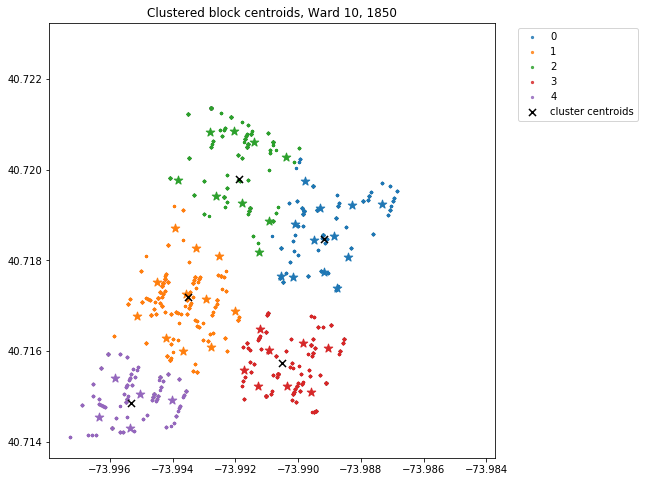

In [10]:
interpolate_sequences = CentroidInterpolator(census_enum_seq, 10, pipeline, all_cols + ['similarity_label'],
                                             KMeans(5), block_centroids)
score, model = interpolate_sequences.kmeans_best(5)
interpolate_sequences.set_clustering_algo(model)
interpolate_sequences.apply_clustering(algo_fit = True)
interpolate_sequences.clustervis(kmeans = True)

## Train and test the model

In [11]:
train,test = interpolate_sequences.stratified_train_test()
interpolate_sequences.train_test_model(train, test)

In [12]:
print("Training score:",interpolate_sequences.train_score)
print("Test score:", interpolate_sequences.test_score)

Training score: 0.984304450655773
Test score: 0.6658206429780034


In [13]:
test['pred_cluster'] = interpolate_sequences.model.predict(test)

In [14]:
test

,level_0,index,block_num,CD_ADDRESS,cd_X,cd_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_NUM,CENSUS_DWELLING_SEQ,...,sequence_len,fixed_seq,dwelling_seq_id,enum_dist_id,enum_dist_order,enum_dist,enum_sequence_len,similarity_label,cluster,pred_cluster
18,24,19,1259.0,24 Division,-73.996688,40.714137,41,4610,4.0,5.0,...,38.0,0,0.0,38,0.0,0.008744,35.0,0,4,4
19,25,18,1259.0,24 Division,-73.996688,40.714137,46,4610,4.0,5.0,...,38.0,0,0.0,38,0.0,0.008744,35.0,0,4,4
20,22,20,1259.0,24 Division,-73.996688,40.714137,21,4610,4.0,5.0,...,38.0,0,0.0,38,0.0,0.008744,35.0,0,4,4
21,23,21,1259.0,24 Division,-73.996688,40.714137,19,4610,4.0,5.0,...,38.0,0,0.0,38,0.0,0.008744,35.0,0,4,4
22,20,22,1259.0,24 Division,-73.996688,40.714137,15,4610,4.0,5.0,...,38.0,0,0.0,38,0.0,0.008744,35.0,0,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23053,23048,23053,186.0,13 Eldridge,-73.993758,40.714793,22,4610,925.0,2053.0,...,18.0,48,1043.0,1970,0.0,0.004445,3.0,1,4,4
23054,23047,23055,186.0,13 Eldridge,-73.993758,40.714793,36,4610,925.0,2053.0,...,18.0,48,1043.0,1970,0.0,0.004445,3.0,1,4,4
23055,23046,23056,186.0,13 Eldridge,-73.993758,40.714793,31,4610,925.0,2053.0,...,18.0,48,1043.0,1970,0.0,0.004445,3.0,1,4,4
23056,23045,23057,186.0,13 Eldridge,-73.993758,40.714793,5,4610,925.0,2053.0,...,18.0,48,1043.0,1970,0.0,0.004445,3.0,1,4,4
